In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from PIL import Image
import torchvision.models as models
from torchvision.utils import save_image

###################################################### NST Architecture using VGG (taking features from only 5 layers) #############################
class VGG(nn.Module):
    def __init__(self):
        super(VGG, self).__init__()
        self.choosen_layers = ['0', '5', '10','11','15']
        self.Vgg = models.vgg19(pretrained=True).features

    def forward(self, x):
        features = []
        for layer_num, layer in enumerate(self.Vgg):
            x = layer(x)
            if str(layer_num) in self.choosen_layers:
                features.append(x)
        return features

def load_image(img):
    image = Image.open(img)
    image = loader(image).unsqueeze(0)  # unsqueeze to add another dim for the batch size of images
    return image.to(device)

############################################################ Initialization #############################################################################
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
image_size = 512
loader = transforms.Compose([transforms.Resize((image_size, image_size)), transforms.ToTensor()])
choosen_layers = ['0', '5', '10','11','15']
original_img = load_image("/content/download.jpeg")
style_img = load_image("/content/12.jpeg")
model = VGG().to(device).eval()  # To freeze the weights

generated_img = original_img.clone().requires_grad_(True)

############################################################ Hyperparameters  #########################################################################################
total_steps = 4000
learning_rate = 0.003
alpha = 1  # for the content loss
beta = 0.01  # How much style we want in the image
optimizer = optim.Adam([generated_img], lr=learning_rate)

############################################################ Generating Image ##################################################################
def NST(original_img, style_img, generated_img, model=model, total_steps=total_steps):
    for step in range(total_steps):
        generated_features = model(generated_img)
        original_features = model(original_img)
        style_features = model(style_img)

        content_loss = 0
        style_loss = 0

        for original_feature, style_feature, generated_feature in zip(original_features, style_features,
                                                                     generated_features):
            batch_size, channel, height, width = generated_feature.shape
            # Content Loss
            content_loss += torch.mean((generated_feature - original_feature) ** 2)

            # Gram Matrices Computation
            G = generated_feature.view(channel, height * width).mm(generated_feature.view(channel, height * width).t())
            S = style_feature.view(channel, height * width).mm(style_feature.view(channel, height * width).t())
            style_loss += torch.mean((G - S) ** 2)

        content_loss /= len(original_features)  # Average content loss across layers
        style_loss /= len(style_features)  # Average style loss across layers

        total_loss = alpha * content_loss + beta * style_loss
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

        if step % 100 == 0:
            print("Steps:", step, "Total loss:", total_loss.item())
            # print("Content Loss",content_loss)
            # print("Style Loss",style_loss)

            save_image(generated_img, "GeneratedImage.png")

    return generated_img

Final_img = NST(original_img, style_img, generated_img, model=model, total_steps=total_steps)


Steps: 0 Total loss: 1515052.25
Steps: 100 Total loss: 70728.296875
Steps: 200 Total loss: 35692.703125
Steps: 300 Total loss: 23490.65625
Steps: 400 Total loss: 16914.19921875
Steps: 500 Total loss: 12708.087890625
Steps: 600 Total loss: 9818.1162109375
Steps: 700 Total loss: 7771.24755859375
Steps: 800 Total loss: 6296.11279296875
Steps: 900 Total loss: 5214.64306640625
Steps: 1000 Total loss: 4403.0546875
Steps: 1100 Total loss: 3775.404052734375
Steps: 1200 Total loss: 3279.112548828125
Steps: 1300 Total loss: 2877.85302734375
Steps: 1400 Total loss: 2547.49853515625
Steps: 1500 Total loss: 2273.695556640625
Steps: 1600 Total loss: 2044.497314453125
Steps: 1700 Total loss: 1851.478271484375
Steps: 1800 Total loss: 1687.98681640625
Steps: 1900 Total loss: 1549.5157470703125
Steps: 2000 Total loss: 1431.1761474609375
Steps: 2100 Total loss: 1328.3643798828125
Steps: 2200 Total loss: 1238.4835205078125
Steps: 2300 Total loss: 1159.6546630859375
Steps: 2400 Total loss: 1089.36840820312

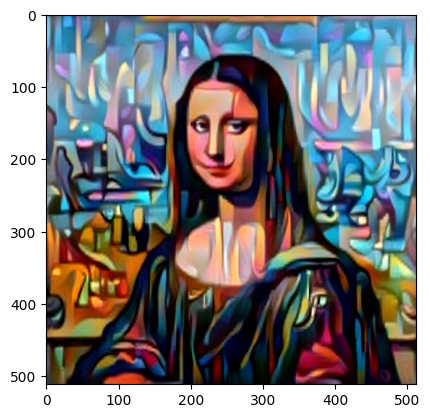

In [3]:
import matplotlib.pyplot as plt

# Save the generated image to a file
save_image(Final_img, "GeneratedImage.png")

# Load the generated image from the file
image = plt.imread("GeneratedImage.png")

# Display the image
plt.imshow(image)
plt.show()

In [4]:
from skimage.metrics import structural_similarity as ssim
import cv2

# Load original and stylized images
original_img = cv2.imread("/content/download.jpeg")
stylized_img = cv2.imread("/content/GeneratedImage.png")

# Resize images to a common size
common_size = (min(original_img.shape[1], stylized_img.shape[1]), min(original_img.shape[0], stylized_img.shape[0]))
original_resized = cv2.resize(original_img, common_size)
stylized_resized = cv2.resize(stylized_img, common_size)

# Convert images to grayscale
original_gray = cv2.cvtColor(original_resized, cv2.COLOR_BGR2GRAY)
stylized_gray = cv2.cvtColor(stylized_resized, cv2.COLOR_BGR2GRAY)

# Calculate SSIM
ssim_index, _ = ssim(original_gray, stylized_gray, full=True)

print(f"Structural Similarity Index (SSI): {ssim_index}")

Structural Similarity Index (SSI): 0.5454563763910333
